## Simulation using Gaussian distributed volumes

In [1]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from math import pi
from utils.sim_functions import complete_measurement



In [2]:
import importlib
import utils.sim_functions
importlib.reload(utils.sim_functions)

from utils.sim_functions import complete_measurement  # re-import updated function

# <span style="color:#EE6594"> *Complete Cropped signal equation - T1 // T 2* // PD & calculation of Flip Angle* </span> </br>
Using gaussian distribution in the spinal cords gray and white matter </br>

Completeing signal equation with T1 and TR block + the effect of the flip angle. <br>
Flip angle should be the ernst angle which by definition is the *arc cos* of exp(-TR/T1). Fixing TR leads to the FA needed to maximize signal from either GM or WM from the spinal cord. <br>

We can compute the fieldmap with all the field of view and then cropped to any size, the simulation will be realistic because the frequency offset effect is already portrayed from the whole body fieldmap calculated. </br>
For this, we are using a bounding box </br>
x: [100, 400] </br>
y: [50, 400] </br>
z: [673, 800] </br>

This is good enough coverage of the cervical spine from brain to C5

Don't forget to create your header in matlab!

### <span style="color:#BC8EC4"> *Guassian Cropped simulation* </span> 

In [ ]:
path_to_cropped_segmentations = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data/ratatouille_swisss_crop.nii.gz"
path_to_cropped_pd = r"E:\msc_data\sc_qsm\new_gauss_sims\sim_inputs\swiss_crop/gauss_pd_sc_swiss_crop.nii.gz"
path_to_cropped_t1 = r"E:\msc_data\sc_qsm\new_gauss_sims\sim_inputs\swiss_crop/gauss_t1_sc_swiss_crop.nii.gz"
path_to_cropped_t2s = r"E:\msc_data\sc_qsm\new_gauss_sims\sim_inputs\swiss_crop/gauss_t2s_sc_swiss_crop.nii.gz"
path_to_cropped_fm_ppm = r"E:\msc_data\sc_qsm\new_gauss_sims\sim_inputs/chi_to_fm_ppm/gauss_fm_ppm_sc_swiss_crop.nii.gz"
######### ####### # # ####### # # # # # # # # #### # # ### #
cropped_segmentations_img = nib.load(path_to_cropped_segmentations)
cropped_segmentations_data = cropped_segmentations_img.get_fdata()      
cropped_dimensions = np.array(cropped_segmentations_data.shape)
cropped_dimensions

array([301, 351, 128])

In [6]:
# Load nifti volumes
crop_pd_pw_img = nib.load(path_to_cropped_pd)
crop_pd_pw_data = crop_pd_pw_img.get_fdata()

crop_t2s_pw_img = nib.load(path_to_cropped_t2s)
crop_t2s_pw_data = crop_t2s_pw_img.get_fdata()

crop_t1_pw_img = nib.load(path_to_cropped_t1)
crop_t1_pw_data = crop_t1_pw_img.get_fdata()

# This is the outcome of giving the susceptibility phantom to Susceptibility to Fieldmap repo
crop_deltaB0_pw_img = nib.load(path_to_cropped_fm_ppm)
crop_dB0_pw_ppm_data = crop_deltaB0_pw_img.get_fdata()

In [ ]:
# Converting fm_ppm to Hz for Groun Truth comparison of BGFR algos:
# Can also be done in the BGFR tuner jup notebook
ground_truth_img = nib.load(r"")
B0=3
f0 = 42.58*B0 # Assuming 3T and 1H 
crop_dB0_pw_Hz_data = crop_dB0_pw_ppm_data * f0 # Convert ppm to Hz

# Create new img
crop_dB0_pw_Hz_img = nib.Nifti1Image(crop_dB0_pw_Hz_data, affine = crop_deltaB0_pw_img.affine)
nib.save(crop_dB0_pw_Hz_img, r"")

In [44]:
# Acquisition parameters:
t1_gm = 984
t1_wm = 857
tr_custom= 45
tr_swiss_acq = 926
fieldStrength = 3 # Tesla

fa_custom_gm = np.rad2deg(np.arccos(np.exp(-tr_custom/((t1_gm+t1_wm)/2)))) # Degrees
fa_swiss_acq = 44
print("Custom FA for (GM+WM)/2: ", fa_custom_gm)
# Echo times must be in seconds
swiss_TE_list = [0.00686, 0.01314, 0.01942, 0.0257, 0.03198]
weird_TEs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.010, 0.015, 0.020, 0.030, 0.040] # This provides better T2* fit but is unrealistic.

Custom FA for (GM+WM)/2:  17.770017170768455


In [22]:
cropped_pw_mag, cropped_pw_phase = complete_measurement(crop_t1_pw_data, crop_pd_pw_data, crop_t2s_pw_data, cropped_dimensions, crop_dB0_pw_ppm_data , fa_swiss_acq, swiss_TE_list, tr_swiss_acq, fieldStrength, handedness= 'right')

Starting optimize_measurement
Flip angle used for:
sin($/alpha$):  0.6946583704589973
1-cos($/alpha$):  0.2806601996613488
Processing TE[0] = 0.00686  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  5.505606617515199j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[1] = 0.01314  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  10.545724628884798j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[2] = 0.01942  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  15.585842640254398j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[3] = 0.0257  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  20.625960651624j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351,

In [23]:
temp_crop_pw_mag = nib.Nifti1Image(cropped_pw_mag, affine = cropped_segmentations_img.affine)
temp_crop_pw_ph = nib.Nifti1Image(cropped_pw_phase, affine = cropped_segmentations_img.affine)

cropped_pw_magnitude_outpath = r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss2_crop_sim_mag_pro.nii.gz"
cropped_pw_phase_outpath = r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss2_crop_sim_ph_pro.nii.gz"

nib.save(temp_crop_pw_mag, cropped_pw_magnitude_outpath)
nib.save(temp_crop_pw_ph, cropped_pw_phase_outpath)

In [30]:
#An example of what a values can rise a overflow in exponential
# This value was in the T2s volume because the gaussian distribution centered at 0.01
# Which was 'air' label created a few pixels with this offlayer values that caused the issue 
# returning infinity and hence ITK could not open the image
#np.exp(-0.008/-4.346339950507538e-06)

C:\Users\User\AppData\Local\Temp\ipykernel_83356\1727653921.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(-0.008/-4.346339950507538e-06)


inf

 # <span style="color:lime">Comparing simulations </span>

 Now, lets load the simulations created, we will use the next code to compare metrics between simulations. First comparing the magnitude and phase components and then loading QSM results and comparing metrics for white and gray matter.

In [24]:
gm_mask_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/gm_mask_crop.nii.gz")
gm_mask_data = gm_mask_img.get_fdata()
wm_mask_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/wm_mask_crop.nii.gz")
wm_mask_data = wm_mask_img.get_fdata()

In [25]:
custom_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal/gauss_crop_sim_mag_pro.nii.gz")
custom_params_sim_mag_data = custom_params_sim_mag_img.get_fdata()
#custom_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal/gauss_crop_sim_ph_pro.nii.gz")
#custom_params_sim_ph_data = custom_params_sim_ph_img.get_fdata()

swiss_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss_crop_sim_mag_pro.nii.gz")
swiss_params_sim_mag_data = swiss_params_sim_mag_img.get_fdata()
#swiss_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss_crop_sim_ph_pro.nii.gz")
#swiss_params_sim_ph_data = swiss_params_sim_ph_img.get_fdata()

In [27]:
n_echoes_custom = custom_params_sim_mag_data.shape[-1]
n_echoes_swiss = swiss_params_sim_mag_data.shape[-1]

In [28]:
wm_ideal_mean = []
gm_ideal_mean = []

wm_swiss_mean = []
gm_swiss_mean = []

for i in range(n_echoes_custom):
    wm_custom_vals = custom_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_custom_vals = custom_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_ideal_mean.append(np.mean(wm_custom_vals))
    gm_ideal_mean.append(np.mean(gm_custom_vals))

for i in range(n_echoes_swiss):
    wm_swiss_vals = swiss_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_swiss_vals = swiss_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_swiss_mean.append(np.mean(wm_swiss_vals))
    gm_swiss_mean.append(np.mean(gm_swiss_vals))

In [29]:
swiss_TE_seconds = [6.86, 13.14, 19.42, 25.7, 31.98]
customs_TE_seconds = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40] 

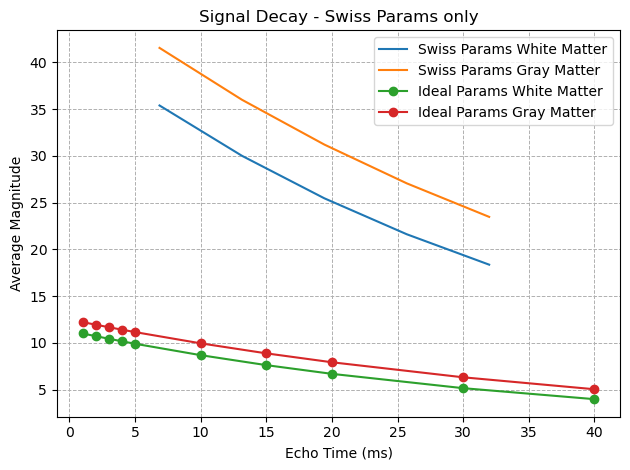

In [31]:
plt.plot(swiss_TE_seconds, wm_swiss_mean, label='Swiss Params White Matter')
plt.plot(swiss_TE_seconds, gm_swiss_mean, label='Swiss Params Gray Matter')
plt.plot(customs_TE_seconds, wm_ideal_mean,'o-', label='Ideal Params White Matter')
plt.plot(customs_TE_seconds, gm_ideal_mean,'o-', label='Ideal Params Gray Matter')
plt.xlabel('Echo Time (ms)')
plt.ylabel('Average Magnitude')
plt.title('Signal Decay - Swiss Params only')
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.yticks()
plt.show()

## <span style="color:#009688">QSM and proceesing steps analysis</span>

### <span style="color:#9575CD">Fieldmap comparison</span>

Values for ideal FM processed with ROMEO have negative values around -400 Hz </br>
Values for swiss FM processed with ROMEO show values near 0 Hz </br>
Perhaps a n*pi offset correction is required.

In [33]:
swiss_TE_seconds[1] - swiss_TE_seconds[0]

6.28

In [39]:
# It looks like there is a n*pi phase wrap happening,
B0=3
central_freq_3T = 42.58*B0 # MHz used at the desired B0
n = 1
gamma = 267.53803037970675 # rad/s.T
delta_TE_swiss = swiss_TE_seconds[1] - swiss_TE_seconds[0]
freq_offset_npi = (n*np.pi)/(delta_TE_swiss*1e-3)
print(f"Frequency offset from a {n} pi wrap: ", freq_offset_npi, " Hz for Swiss FM processed with ROMEO")

Frequency offset from a 1 pi wrap:  500.2536072595212  Hz for Swiss FM processed with ROMEO


In [36]:
# Load the fieldmap and correct for 1 pi phase wrap
gauss_swiss_romeo_fm_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss\fm_tests\test2_msk_apply/B0.nii")
gauss_swiss_romeo_fm_data = gauss_swiss_romeo_fm_img.get_fdata()

gauss_swiss_romeo_fm_corrected = gauss_swiss_romeo_fm_data - freq_offset_npi
gauss_swiss_romeo_fm_corrected_img = nib.Nifti1Image(gauss_swiss_romeo_fm_corrected, affine = gauss_swiss_romeo_fm_img.affine)
nib.save(gauss_swiss_romeo_fm_corrected_img, r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss\fm_tests\test2_msk_apply/B0_corrected.nii.gz")